# serve

> Fill in a module description here

In [1]:
#| default_exp serve

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export

import tempfile
import os
import io
import base64
import PIL
import random
from pprint import pprint
from typing import Tuple

import torch
from diffusers import StableDiffusionPipeline

import pydantic


from datascience_toolkits.fastapi import create_app, serve

from airt.utils import get_image_size_from_aspect_ratio

In [5]:
#| export

device = torch.device('cuda')

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, revision="fp16")

def do_nothing(clip_input, images):
    return images, [0] * len(images)


pipe.safety_checker = do_nothing
pipe = pipe.to(device)

_ = pipe("", num_inference_steps=1)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# aspect ratio

In [52]:
cfg = 7.5

torch.manual_seed(344000)

In [53]:
pipe_out = pipe(prompt=prompt, 
                width=width, height=height, 
                guidance_scale=cfg, num_inference_steps=30)

  0%|          | 0/31 [00:00<?, ?it/s]

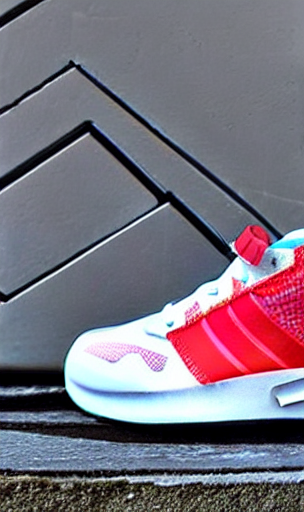

In [54]:
pipe_out.images[0]

# api

In [60]:
#| export 

class Request(pydantic.BaseModel):
    prompt: str
    steps: int = 1
    guidance_scale: float = 7.5
    negative_prompt: str = None
    batch_size: int = 1
    seed: int = None
    mode: str = "txt2img"
    init_image: str = None
    strength: float = 0.8
    aspect_ratio: float = 1
        

async def txt2img(req: Request):
    pprint(req)
    tempdir = tempfile.gettempdir()
    local_dir = os.path.join(tempdir, "test.png")
    
    seed = req.seed if req.seed else random.randint(1, 1000000000)
    torch.manual_seed(seed)
    
    width, height = get_image_size_from_aspect_ratio(req.aspect_ratio)

    pipe_out = pipe(
        prompt=req.prompt, 
        width=width,
        height=height,
        num_inference_steps=req.steps,
        guidance_scale=req.guidance_scale,
        negative_prompt=req.negative_prompt,
    )
    images = pipe_out.images

    
    b64images = []
    for img in images:
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue())
        b64images.append(img_str.decode())
    return {
        'images': b64images,
        'seed': seed,
    }
    

route_info = [{
    "path": "/",
    "method": "post",
    "endpoint": txt2img
}]

app = create_app(route_info)
serve(app, port=8000)

t=2022-10-26T04:48:41+0000 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040
INFO:     Started server process [26757]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


http://b8e5-54-249-55-5.ngrok.io
Request(prompt='test', steps=50, guidance_scale=7.5, negative_prompt=None, batch_size=1, seed=None, mode='txt2img', init_image=None, strength=0.8, aspect_ratio=1)


  0%|          | 0/51 [00:00<?, ?it/s]

INFO:     127.0.0.1:35924 - "POST / HTTP/1.1" 200 OK
Request(prompt='test', steps=50, guidance_scale=7.5, negative_prompt=None, batch_size=1, seed=None, mode='txt2img', init_image=None, strength=0.8, aspect_ratio=0.75)


  0%|          | 0/51 [00:00<?, ?it/s]

INFO:     127.0.0.1:51952 - "POST / HTTP/1.1" 200 OK
Request(prompt='test', steps=50, guidance_scale=7.5, negative_prompt=None, batch_size=1, seed=None, mode='txt2img', init_image=None, strength=0.8, aspect_ratio=0.5)


  0%|          | 0/51 [00:00<?, ?it/s]

INFO:     127.0.0.1:57404 - "POST / HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [26757]


'http://b8e5-54-249-55-5.ngrok.io'

In [4]:
#| hide
import nbdev; nbdev.nbdev_export()